In [ ]:
import pandas as pd

dataf = pd.read_csv("Combined_News_DJIA.csv", encoding='latin-1')

s = []
for i in range(1, 26):
    s += ["Top" + str(i)]

data_list = []

for i in range(25):
    data_list.append(dataf[s[i]].tolist())

for i in range(25):
    for j in range(len(dataf)):
        if type(data_list[i][j]) == float:
            data_list[i][j] = "None"
        else:
            data_list[i][j] = data_list[i][j][2:-1]

num_features = 1

if (num_features > 1):
    topn = []

    for j in range(len(dataf)):
      x = ""

      for i in range(num_features - 1):
        x += data_list[i][j] + " "
      x += data_list[num_features - 1][j]
      topn.append(x)

    new_df = pd.DataFrame({"Top1" : topn, "Label" : dataf["Label"].tolist()})

else:
    new_df = dataf

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=180, tokenizer_name='bert-base-uncased'):
        self.texts = dataframe['Top1'].values
        self.targets = dataframe['Label'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
            'targets': torch.as_tensor(target, dtype=torch.long),
            'text': text
        }

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(new_df, train_size=0.9, shuffle=True, random_state=1702)
print('{:>5,} Training samples'.format(len(train_data)))
print('{:>5,} Validation samples'.format(len(test_data)))

train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

1,790 Training samples
  199 Validation samples


In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset))

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

from torch import cuda
torch.cuda.empty_cache()
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

import time
import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

training_stats = []
epoch_loss_train = []
total_t0 = time.time()

# TRAINING
for epoch in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    print("")
    print("================ Epoch {:} / {:} ================".format(epoch, EPOCHS))
    train_all_predictions = []
    train_all_true_labels = []
    for step, data in enumerate(train_loader):
        if step % 40 == 0 and not step == 0:
            elapsed = int(round(time.time() - t0))
            elapsed = str(datetime.timedelta(seconds=elapsed))
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_loader), elapsed
                )
            )

        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        model.zero_grad()

        loss, logits = model(
            ids, token_type_ids=None, attention_mask=mask, labels=targets
        ).to_tuple()
        epoch_loss_train.append(loss.item())

        cpu_logits = logits.cpu().detach().numpy()
        train_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        train_all_true_labels.extend(targets.cpu().numpy())

        loss.backward()
        optimizer.step()
    train_accuracy = accuracy_score(train_all_true_labels, train_all_predictions)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        train_all_true_labels, train_all_predictions, average="binary"
    )

    print("")
    print('---TRAIN METRICS---')
    print(f"Loss: {np.mean(epoch_loss_train):.4f}")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-Score: {train_f1:.4f}")
    print("")

    # VALIDATION
    print("Running validation ...")
    print("")
    model.eval()
    epoch_loss_test = []
    test_all_predictions = []
    test_all_true_labels = []
    for data in test_loader:
        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        with torch.no_grad():
            loss, logits = model(ids, token_type_ids=None, attention_mask=mask, labels=targets).to_tuple()

        epoch_loss_test.append(loss.item())
        cpu_logits = logits.cpu().detach().numpy()
        test_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        test_all_true_labels.extend(targets.cpu().numpy())
    test_accuracy = accuracy_score(test_all_true_labels, test_all_predictions)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        test_all_true_labels, test_all_predictions, average="binary"
    )
    print("")
    print('---TEST METRICS---')
    print(f"Loss: {np.mean(epoch_loss_test):.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")

    training_stats.append(
            {
            'epoch': epoch,
            'Training Loss': np.mean(epoch_loss_train),
            'Training Accuracy': train_accuracy,
            'Training Precision': train_precision,
            'Training Recall': train_recall,
            'Training F1': train_f1,
            'Validation Loss': np.mean(epoch_loss_test),
            'Validation Accuracy': test_accuracy,
            'Validation Precision': test_precision,
            'Validation Recall': test_recall,
            'Validation F1': test_f1
        }
    )


================ Epoch 1 / 10 ================
  Batch    40  of    112.    Elapsed: 0:00:08.
  Batch    80  of    112.    Elapsed: 0:00:17.

---TRAIN METRICS---
Loss: 0.7020
Accuracy: 0.4994
Precision: 0.5211
Recall: 0.6413
F1-Score: 0.5750

Running validation ...


---TEST METRICS---
Loss: 0.6787
Accuracy: 0.6030
Precision: 0.6073
Recall: 0.9667
F1-Score: 0.7460

================ Epoch 2 / 10 ================
  Batch    40  of    112.    Elapsed: 0:00:09.
  Batch    80  of    112.    Elapsed: 0:00:17.

---TRAIN METRICS---
Loss: 0.6941
Accuracy: 0.5475
Precision: 0.5502
Recall: 0.7831
F1-Score: 0.6463

Running validation ...


---TEST METRICS---
Loss: 0.6880
Accuracy: 0.5126
Precision: 0.6386
Recall: 0.4417
F1-Score: 0.5222

================ Epoch 3 / 10 ================
  Batch    40  of    112.    Elapsed: 0:00:08.
  Batch    80  of    112.    Elapsed: 0:00:17.

---TRAIN METRICS---
Loss: 0.6793
Accuracy: 0.6268
Precision: 0.6357
Recall: 0.6868
F1-Score: 0.6602

Running validation .

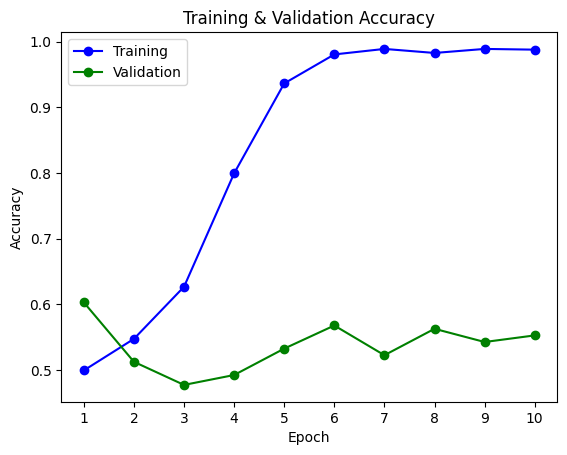

In [ ]:
#This code is coppied from the following source:
# https://www.kaggle.com/code/mexwell/bert-for-binary-classification

import matplotlib.pyplot as plt

df_statistics = pd.DataFrame(data=training_stats)
df_statistics = df_statistics.set_index('epoch')

plt.plot(df_statistics['Training Accuracy'], 'b-o', label='Training')
plt.plot(df_statistics['Validation Accuracy'], 'g-o', label='Validation')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()